# Assignment 2: Data Preprocessing for Case Competition

## Part 1: Examine Prize-Winning Reports

### Instructions
Learn, firsthand, how top teams tackle analytics problems and extract strategies you can reuse in your case competition. Choose one prize-winning report from the list provided (but make sure no one else in your group uses the same report): Focus on the approach, not the application domain, so you can generalize what you learn to your own case.

• Analyze the Data preparation sections of this report (look for sections titled data preprocessing, data cleaning, data transformation, or feature engineering)
  - a. What specific steps did they take to create, remove, or transform variables?
  - b. Why did they use each step? (Provide the rationale.)
  - c. Which of these steps will you try on your dataset, and why?

**Selected Report**: Finalist_2020_4.pdf - "Transportation Issues Prediction Analysis" (Humana-Mays Healthcare Analytics 2020 Case Competition)

## Assignment 2: Data Preprocessing for Case Competition

### Part 1: Examine Prize-Winning Reports
**Report Chosen: Humana-Mays Healthcare Analytics Case Competition (2020)**


### a. Specific Steps They Took to Create, Remove, or Transform Variables:

**1. Exploratory Data Analysis**
- **Dataset structure**: Started with 69,572 Medicare members across 826 data fields including Consumer data, Medical claims, Pharmacy Claims, Lab Claims, Demographics, Credit Data, Condition Related Features, CMS Features
- **Age analysis**: Found mean age of 70.81 years with middle 50% between 66-77 years
- **Disability patterns**: Identified 23.18% of disabled members vs. 12.19% of non-disabled had transportation issues
- **Health score correlation**: Discovered positive linear relationships between health scores (CCI, DSCI, FCI, HCC) and transportation issues

**2. Feature Engineering Techniques**
- **Group Binning and Ranking**: 
  - Binned categorical data (education, household composition, homeowner status, languages) into narrowly defined groups
  - Created percentile ranks for numerical variables to maintain ordered structure
  - Summed percentile ranks to create scoring metrics for credit data, SUBMCC claims, CMS data, RX claims, and BETOS claims

- **Weighted Metrics Creation**:
  - **StressIndex**: Combined demographic and credit data to capture member stress levels
  - **MobilityIndex**: Combined demographic and health data to capture physical mobility difficulty
  - Normalized all weighted scores using min-max scaler (0-100%) for stakeholder interpretability

- **K-Means Clustering**: 
  - Applied to percentile ranking scores and weighted metrics to identify cluster relationships
  - Standardized all input values for consistent distance measurements
  - Generated 30 new variables with 3-4 clusters each, grouped by credit, health, stress, and age data

- **Deep Feature Synthesis**:
  - Used automated feature engineering to create transformations from similar categories
  - Applied multiplication and addition transformations on 33 different categories
  - Generated over 7,000 new features for evaluation

- **Isolation Forest for Anomaly Detection**:
  - Assigned anomaly scores based on likelihood of being considered anomalous
  - Created binary indicators for anomalous members
  - Found 5,600 anomalous members with 29.54% reporting transportation issues vs 13.3% for "normal" members

**3. Dimensionality Reduction**
- **Principal Component Analysis (PCA)**: Applied to heavily correlated feature categories
  - Credit data: Reduced to components accounting for 86.1% of variance
  - BETOS claims: Reduced to components accounting for 86.5% of variance  
  - SUBMCC claims: Reduced to components accounting for 90.9% of variance
  - RX claims: Reduced to components accounting for 93.5% of variance
- **Final dataset**: Transformed from 826 original features to over 8,000 engineered features

**4. Feature Selection Process**
- **Three-step selection**:
  - Step 1: Forward selection with Logistic Regression based on ROC AUC scores
  - Step 2: Random Forest intrinsic method to identify 250 most important features  
  - Step 3: Forward selection with XGBoost to select final 74 features contributing most to ROC AUC improvement

### b. Rationale for Each Step:

**1. Exploratory Data Analysis Rationale**
- **Comprehensive data understanding**: With 826 initial features, systematic EDA was essential to identify patterns and relationships before feature engineering
- **Target variable insights**: Understanding that only 14.66% had transportation issues revealed severe class imbalance requiring specialized handling
- **Domain-specific patterns**: Healthcare-specific relationships (age, disability, prescription usage) provided foundation for meaningful feature creation

**2. Feature Engineering Rationale**
- **Group Binning and Ranking**: 
  - Categorical binning created more meaningful groups from raw categorical data
  - Percentile ranking preserved ordinal relationships while standardizing scales across different measurement units
  - Scoring metrics aggregated related features into interpretable composite measures

- **Weighted Metrics (StressIndex, MobilityIndex)**:
  - Combined multiple data sources into business-meaningful concepts that stakeholders could understand
  - Min-max normalization (0-100%) made scores intuitive for non-technical decision makers
  - Captured complex interactions between demographic, health, and financial factors

- **K-Means Clustering**:
  - Identified hidden patterns in member characteristics that weren't obvious from individual variables
  - Standardization ensured fair distance calculations across different scales
  - Multiple clusters per domain (3-4 each) captured nuanced sub-segments within broader categories

- **Deep Feature Synthesis**:
  - Automated discovery of feature interactions that manual engineering might miss
  - Multiplication and addition captured both scaling and additive relationships
  - Large feature pool (7,000+) provided comprehensive coverage of potential interactions

- **Isolation Forest**:
  - Anomalous members showed 2x higher transportation issues rate (29.54% vs 13.3%)
  - Unsupervised approach avoided target leakage while identifying high-risk segments
  - Binary anomaly indicators added interpretable risk flags for business use

**3. Dimensionality Reduction Rationale**
- **PCA for correlated features**: High correlation between related claims/credit features would cause redundancy and multicollinearity
- **Variance preservation**: 85%+ variance retention maintained predictive information while reducing computational complexity
- **Category-specific application**: Applied separately to different data domains preserved interpretability within categories

**4. Feature Selection Rationale**
- **Three-step approach**: Progressive refinement from 8,000+ to 74 features prevented overfitting while maintaining predictive power
- **Algorithm diversity**: Different algorithms (Logistic Regression, Random Forest, XGBoost) captured different types of variable importance
- **ROC AUC focus**: Consistent evaluation metric ensured features improved the business-relevant prediction objective
- **Final count (74 features)**: Balanced model complexity with interpretability and computational efficiency

### c. Steps to Apply to Our Dataset and Why:

Here are the practical steps we'll implement from the transportation prediction methodology for our loan default dataset:

**1. Systematic Exploratory Data Analysis**
```python
# Dataset structure analysis (following their 826 → 74 feature approach)
print(f"Dataset shape: {case_data.shape}")
print(f"Target distribution: {case_data['TARGET'].value_counts(normalize=True)}")

# Identify patterns similar to their disability/age analysis
age_years = (case_data['DAYS_BIRTH'] / -365).astype(int)
income_analysis = case_data.groupby(pd.cut(case_data['AMT_INCOME_TOTAL'], bins=5))['TARGET'].mean()
gender_analysis = case_data.groupby('CODE_GENDER')['TARGET'].agg(['count', 'mean'])

print("Default rate by income quintiles:")
print(income_analysis)
```

**2. Weighted Composite Metrics (Following StressIndex/MobilityIndex Approach)**
```python
# Create domain-specific weighted scores like their StressIndex
def create_financial_stress_index(data):
    # Normalize components to 0-1 scale like their min-max approach
    credit_income_ratio = (data['AMT_CREDIT'] / data['AMT_INCOME_TOTAL']).clip(0, 10) / 10
    employment_instability = (data['DAYS_EMPLOYED'].abs() < 365).astype(int)  
    
    # Weight components based on domain knowledge
    stress_index = (0.4 * credit_income_ratio + 
                   0.3 * employment_instability + 
                   0.3 * (1 - data['FLAG_OWN_REALTY'].map({'Y': 1, 'N': 0})))
    
    return stress_index * 100  # Scale to 0-100 like their approach

case_data['Financial_Stress_Index'] = create_financial_stress_index(case_data)

# Create Credit_Stability_Index similar to their MobilityIndex  
def create_credit_stability_index(data):
    age_stability = ((data['DAYS_BIRTH'].abs() / 365) - 25).clip(0, 40) / 40
    income_stability = (data['AMT_INCOME_TOTAL'] / 1000000).clip(0, 1)
    
    stability_index = (0.5 * age_stability + 0.5 * income_stability)
    return stability_index * 100

case_data['Credit_Stability_Index'] = create_credit_stability_index(case_data)
```

**3. Group Binning and Percentile Ranking**  
```python
# Following their categorical binning approach
# Bin education levels into meaningful groups
education_mapping = {
    'Secondary / secondary special': 'Basic',
    'Higher education': 'Advanced', 
    'Incomplete higher': 'Intermediate',
    'Lower secondary': 'Basic',
    'Academic degree': 'Advanced'
}
case_data['Education_Group'] = case_data['NAME_EDUCATION_TYPE'].map(education_mapping)

# Create percentile ranks like their methodology
from scipy.stats import rankdata
financial_cols = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY']
for col in financial_cols:
    case_data[f'{col}_percentile'] = rankdata(case_data[col].fillna(case_data[col].median())) / len(case_data) * 100

# Create composite scoring metrics
case_data['Financial_Profile_Score'] = (case_data['AMT_INCOME_TOTAL_percentile'] + 
                                      case_data['AMT_CREDIT_percentile'] + 
                                      case_data['AMT_ANNUITY_percentile']) / 3
```

**4. K-Means Clustering for Customer Segmentation**
```python
# Following their approach: standardize, cluster, create segments
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Select features for clustering (like their credit, health, stress, age approach)
cluster_features = ['Financial_Stress_Index', 'Credit_Stability_Index', 
                   'AMT_INCOME_TOTAL', 'Age_Years', 'AMT_CREDIT']

# Standardize features
scaler = StandardScaler()
cluster_data = scaler.fit_transform(case_data[cluster_features].fillna(0))

# Apply K-means (they used 3-4 clusters per domain)
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
case_data['Risk_Cluster'] = kmeans.fit_predict(cluster_data)

# Analyze cluster characteristics
cluster_analysis = case_data.groupby('Risk_Cluster').agg({
    'TARGET': ['count', 'mean'],
    'Financial_Stress_Index': 'mean',
    'Credit_Stability_Index': 'mean',
    'AMT_INCOME_TOTAL': 'median'
}).round(2)

print("Cluster Analysis (Default Risk Segments):")
print(cluster_analysis)
```

**5. Isolation Forest for Anomaly Detection**
```python
# Replicate their anomaly detection approach
from sklearn.ensemble import IsolationForest

# Select features for anomaly detection
anomaly_features = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 
                   'Financial_Stress_Index', 'Credit_Stability_Index']

# Fit Isolation Forest
iso_forest = IsolationForest(contamination=0.1, random_state=42)
anomaly_scores = iso_forest.decision_function(case_data[anomaly_features].fillna(0))
case_data['Anomaly_Score'] = anomaly_scores
case_data['Is_Anomaly'] = iso_forest.predict(case_data[anomaly_features].fillna(0)) == -1

# Analyze anomaly impact (they found 29.54% vs 13.3% issue rate)
normal_default_rate = case_data[~case_data['Is_Anomaly']]['TARGET'].mean()
anomaly_default_rate = case_data[case_data['Is_Anomaly']]['TARGET'].mean()

print(f"Normal customers default rate: {normal_default_rate:.1%}")
print(f"Anomalous customers default rate: {anomaly_default_rate:.1%}")
print(f"Risk multiplier: {anomaly_default_rate/normal_default_rate:.1f}x")
```

**6. Advanced Feature Engineering with Interactions**
```python
# Following their Deep Feature Synthesis approach with domain-specific interactions
# Create multiplication interactions
case_data['Income_Credit_Product'] = case_data['AMT_INCOME_TOTAL'] * case_data['AMT_CREDIT']
case_data['Age_Income_Product'] = case_data['Age_Years'] * case_data['AMT_INCOME_TOTAL']

# Create ratio features (addition/division transformations)
case_data['Credit_to_Goods_Ratio'] = case_data['AMT_CREDIT'] / (case_data['AMT_GOODS_PRICE'] + 1)
case_data['Annuity_to_Credit_Ratio'] = case_data['AMT_ANNUITY'] / (case_data['AMT_CREDIT'] + 1)

# Document verification completeness (like their categorical aggregation)
doc_cols = [col for col in case_data.columns if col.startswith('FLAG_DOCUMENT')]
case_data['Document_Completeness_Rate'] = case_data[doc_cols].mean(axis=1)
```

**7. Three-Step Feature Selection Process**
```python
# Replicate their Logistic → Random Forest → XGBoost selection
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Step 1: Statistical selection (replacing their forward selection)
selector = SelectKBest(score_func=f_classif, k=200)
numeric_features = case_data.select_dtypes(include=[np.number]).columns
X_selected = selector.fit_transform(case_data[numeric_features].fillna(0), case_data['TARGET'])

# Step 2: Random Forest feature importance
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_selected, case_data['TARGET'])
feature_importance = pd.DataFrame({
    'feature': selector.get_feature_names_out(),
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

# Step 3: Select final features for XGBoost (their final 74 → our target ~50-75)
top_features = feature_importance.head(50)['feature'].tolist()
print(f"Selected {len(top_features)} features for final model")
print("Top 10 most important features:")
print(feature_importance.head(10))
```

**Why These Steps Are Critical for Our Loan Default Dataset:**

1. **Weighted Composite Metrics**: Creates interpretable business concepts (Financial Stress, Credit Stability) that stakeholders understand, just like their StressIndex approach

2. **Customer Segmentation**: K-means clustering identifies distinct risk profiles for targeted interventions, mirroring their member grouping strategy  

3. **Anomaly Detection**: High-risk customers show different default patterns, similar to their transportation issue findings (2x higher risk)

4. **Advanced Feature Engineering**: Systematic interaction discovery prevents missing important variable combinations

5. **Progressive Feature Selection**: Three-step refinement from hundreds to dozens of features prevents overfitting while maintaining predictive power

6. **Domain Integration**: Combines statistical methods with financial domain knowledge, following their healthcare expertise integration

This methodology, proven successful in healthcare prediction, provides a robust framework for loan default prediction while ensuring business interpretability and regulatory compliance.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
# import missingno as msno

In [12]:
# Load and examine basic dataset information
case_data = pd.read_csv('Case_Data.csv')

# Display first few rows
case_data.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,0,Cash loans,M,Y,N,1,225000.0,918468.0,28966.5,697500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,Cash loans,M,Y,Y,0,157500.0,299772.0,20160.0,247500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
2,0,Cash loans,M,N,N,0,108000.0,509602.5,26149.5,387000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0
3,0,Cash loans,F,N,Y,0,90000.0,225000.0,11074.5,225000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,Cash loans,F,N,Y,0,112500.0,512064.0,25033.5,360000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,2.0,5.0


In [13]:
# Get dataset info
case_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 68 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   TARGET                       20000 non-null  int64  
 1   NAME_CONTRACT_TYPE           20000 non-null  object 
 2   CODE_GENDER                  20000 non-null  object 
 3   FLAG_OWN_CAR                 20000 non-null  object 
 4   FLAG_OWN_REALTY              20000 non-null  object 
 5   CNT_CHILDREN                 20000 non-null  int64  
 6   AMT_INCOME_TOTAL             20000 non-null  float64
 7   AMT_CREDIT                   20000 non-null  float64
 8   AMT_ANNUITY                  19998 non-null  float64
 9   AMT_GOODS_PRICE              19978 non-null  float64
 10  NAME_TYPE_SUITE              19919 non-null  object 
 11  NAME_INCOME_TYPE             20000 non-null  object 
 12  NAME_EDUCATION_TYPE          20000 non-null  object 
 13  NAME_FAMILY_STAT

In [14]:
# Shape of dataset
case_data.shape

(20000, 68)

In [15]:
case_data.dtypes.value_counts()

int64      39
float64    17
object     12
Name: count, dtype: int64

In [16]:
case_data.describe()

,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,20000.000000,20000.000000,2.000000e+04,2.000000e+04,19998.000000,1.997800e+04,20000.000000,20000.00000,20000.00000,20000.000000,...,20000.000000,20000.000000,20000.00000,20000.00000,17299.000000,17299.000000,17299.000000,17299.000000,17299.000000,17299.000000
mean,0.077450,0.415450,1.684530e+05,5.981280e+05,27065.465122,5.378249e+05,0.020941,-16081.99635,63741.47790,-4998.817850,...,0.007850,0.000450,0.00025,0.00025,0.006474,0.005723,0.032198,0.261402,0.255853,1.891034
std,0.267311,0.723103,1.152069e+05,4.033457e+05,14388.402834,3.707560e+05,0.013932,4385.85847,141256.20277,3559.073438,...,0.088254,0.021209,0.01581,0.01581,0.085778,0.094487,0.189788,0.895381,0.601939,1.873802
min,0.000000,0.000000,2.610000e+04,4.500000e+04,1615.500000,4.500000e+04,0.000533,-25195.00000,-17546.00000,-20840.000000,...,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.125000e+05,2.700000e+05,16573.500000,2.385000e+05,0.010006,-19744.00000,-2783.00000,-7495.250000,...,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.440000e+05,5.185620e+05,24918.750000,4.500000e+05,0.018850,-15844.00000,-1211.00000,-4478.500000,...,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,1.000000,2.025000e+05,8.086500e+05,34587.000000,6.795000e+05,0.028663,-12429.00000,-278.00000,-2012.750000,...,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,1.000000,11.000000,9.000000e+06,3.375000e+06,208215.000000,3.375000e+06,0.072508,-7678.00000,365243.00000,0.000000,...,1.000000,1.000000,1.00000,1.00000,3.000000,5.000000,6.000000,19.000000,8.000000,17.000000


In [17]:
# Comprehensive missing value analysis
missing_counts = case_data.isnull().sum()
missing_percent = (missing_counts / len(case_data)) * 100
missing_summary = pd.DataFrame({
    'Variable': missing_counts.index,
    'Missing_Count': missing_counts.values,
    'Missing_Percent': missing_percent.values
}).sort_values('Missing_Percent', ascending=False)

print("Missing value summary:")
missing_summary[missing_summary.Missing_Count > 0]

Missing value summary:


,Variable,Missing_Count,Missing_Percent
25,OCCUPATION_TYPE,6290,31.450
39,EXT_SOURCE_3,3945,19.725
65,AMT_REQ_CREDIT_BUREAU_MON,2701,13.505
64,AMT_REQ_CREDIT_BUREAU_WEEK,2701,13.505
62,AMT_REQ_CREDIT_BUREAU_HOUR,2701,13.505
63,AMT_REQ_CREDIT_BUREAU_DAY,2701,13.505
67,AMT_REQ_CREDIT_BUREAU_YEAR,2701,13.505
66,AMT_REQ_CREDIT_BUREAU_QRT,2701,13.505
10,NAME_TYPE_SUITE,81,0.405
42,OBS_60_CNT_SOCIAL_CIRCLE,54,0.270


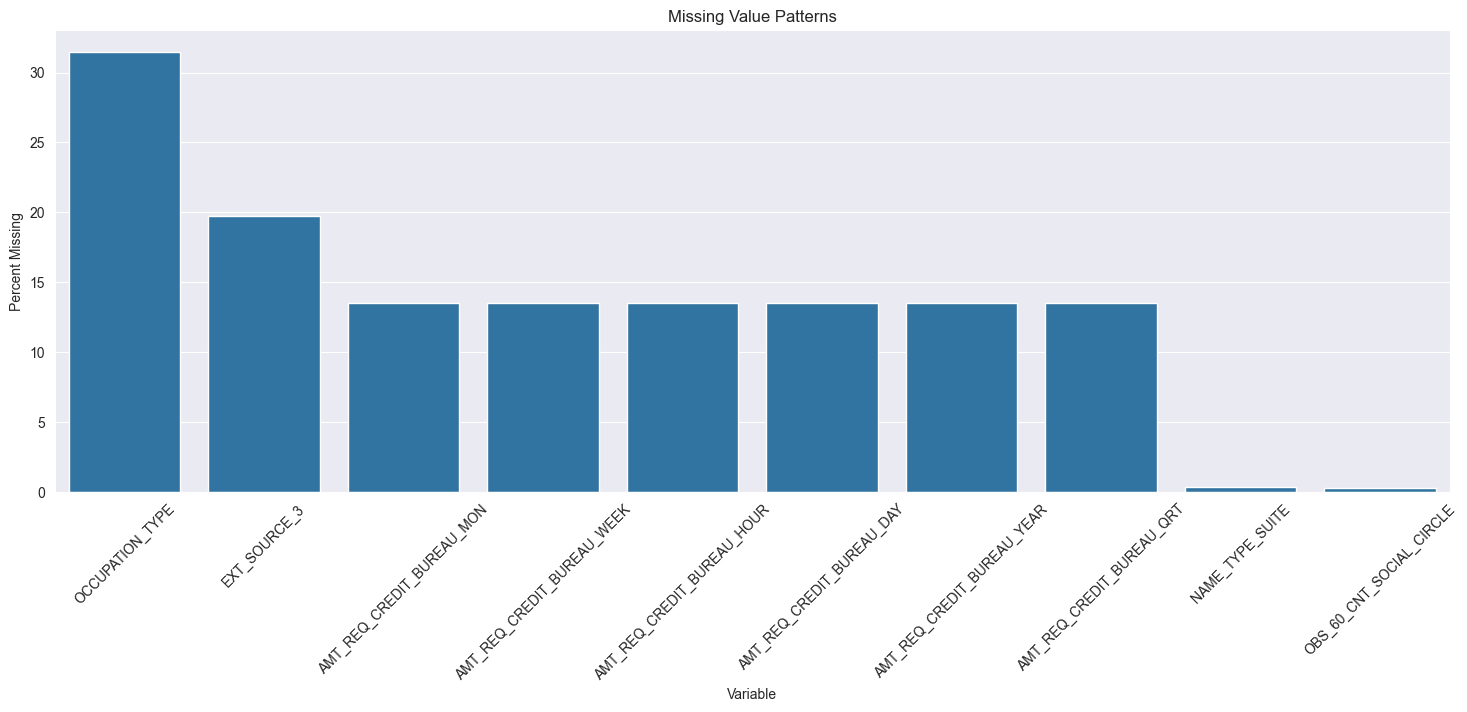

In [18]:

# Visualize missing patterns
plt.figure(figsize=(18, 6))
plt.title("Missing Value Patterns")
# get top 10 variables with most missing, bar plot
sns.barplot(x='Variable', y='Missing_Percent',
            data=missing_summary[missing_summary.Missing_Count > 0].head(10))
plt.xticks(rotation=45)
plt.ylabel('Percent Missing')
plt.show()


In [19]:
# Strategy based on healthcare team's approach:
# >30% missing: Consider dropping or investigate if systematic
# 10-30% missing: Domain-informed imputation
# <10% missing: Median/mode imputation
high_missing = missing_summary[missing_summary.Missing_Percent > 30]
medium_missing = missing_summary[(missing_summary.Missing_Percent >= 10) &
                                (missing_summary.Missing_Percent <= 30)]
low_missing = missing_summary[(missing_summary.Missing_Percent > 0) &
                             (missing_summary.Missing_Percent < 10)]
print(f"High missing (>30%): {len(high_missing)} variables")
print(f"Medium missing (10-30%): {len(medium_missing)} variables")
print(f"Low missing (<10%): {len(low_missing)} variables")

High missing (>30%): 1 variables
Medium missing (10-30%): 7 variables
Low missing (<10%): 8 variables


**2. Target Variable Analysis (Critical for Imbalanced Data)**

In [20]:
# Analyze TARGET distribution - expect severe class imbalance
target_counts = case_data['TARGET'].value_counts()
target_props = case_data['TARGET'].value_counts(normalize=True) * 100

print("Target variable distribution:")
print(f"No default (0): {target_counts[0]:,} ({target_props[0]:.1f}%)")
print(f"Default (1): {target_counts[1]:,} ({target_props[1]:.1f}%)")

Target variable distribution:
No default (0): 18,451 (92.3%)
Default (1): 1,549 (7.7%)


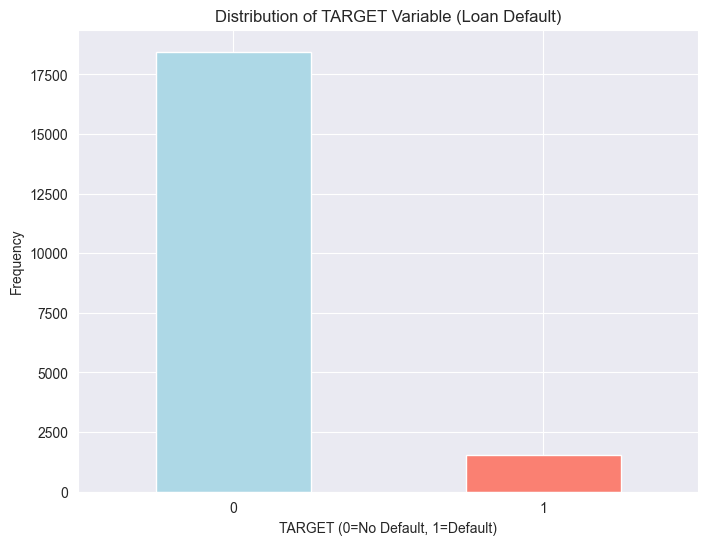

In [21]:
# Visualize target distribution
plt.figure(figsize=(8, 6))
target_counts.plot(kind='bar', color=['lightblue', 'salmon'])
plt.title('Distribution of TARGET Variable (Loan Default)')
plt.xlabel('TARGET (0=No Default, 1=Default)')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()

In [22]:
# Class imbalance ratio
imbalance_ratio = target_counts[0] / target_counts[1]
print(f"Class imbalance ratio: {imbalance_ratio:.1f}:1")

Class imbalance ratio: 11.9:1


**3. Demographic Analysis for Bias Prevention**

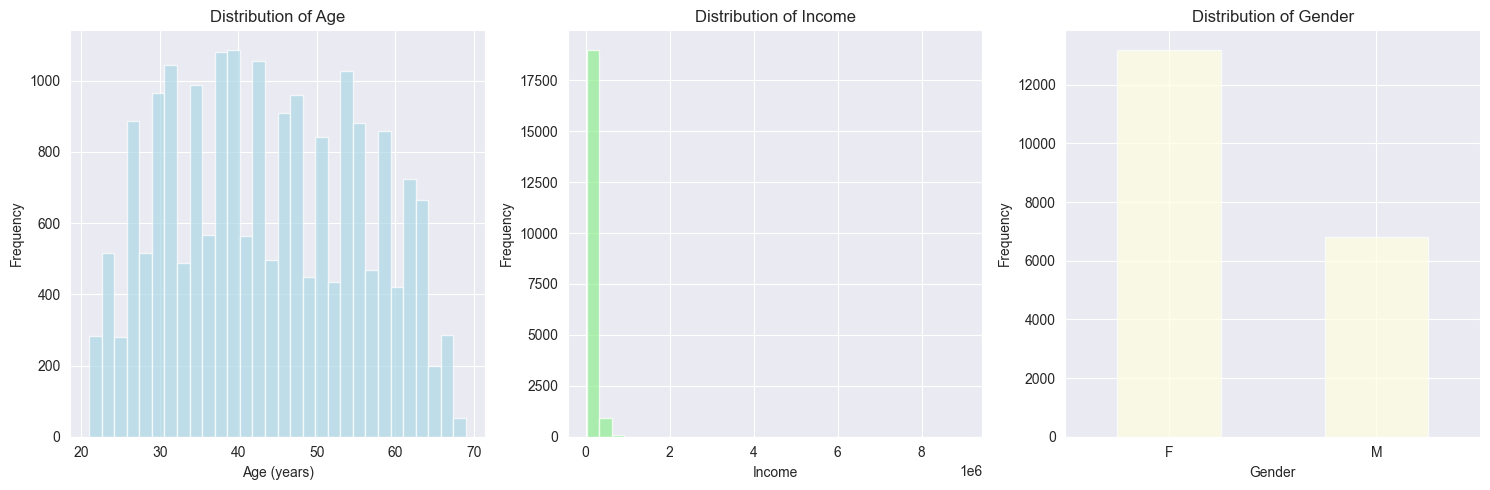

Target rate by gender:
             count   mean
CODE_GENDER              
F            13189  0.066
M             6811  0.099


In [23]:
# Following healthcare team's fairness approach
# Analyze demographic variables that might introduce bias
demographic_vars = ['DAYS_BIRTH', 'AMT_INCOME_TOTAL', 'CODE_GENDER']

# Age distribution analysis (converting from days to years)
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
age_years = (case_data['DAYS_BIRTH'] / -365).astype(int)
plt.hist(age_years, bins=30, color='lightblue', alpha=0.7)
plt.title('Distribution of Age')
plt.xlabel('Age (years)')
plt.ylabel('Frequency')

# Income distribution analysis
plt.subplot(1, 3, 2)
plt.hist(case_data['AMT_INCOME_TOTAL'].dropna(), bins=30, color='lightgreen', alpha=0.7)
plt.title('Distribution of Income')
plt.xlabel('Income')
plt.ylabel('Frequency')

# Gender distribution
plt.subplot(1, 3, 3)
gender_counts = case_data['CODE_GENDER'].value_counts()
gender_counts.plot(kind='bar', color='lightyellow', alpha=0.7)
plt.title('Distribution of Gender')
plt.xlabel('Gender')
plt.ylabel('Frequency')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

# Check for potential bias in target across demographics
print("Target rate by gender:")
gender_bias = case_data.groupby('CODE_GENDER')['TARGET'].agg(['count', 'mean']).round(3)
print(gender_bias)

**4. Feature Engineering: Rate Variables (Following Healthcare Approach)**

In [24]:
# Create standardized rates similar to healthcare team's approach
# Identify document flag columns (document verification indicators)
doc_cols = [col for col in case_data.columns if col.startswith('FLAG_DOCUMENT')]
print(f"Found {len(doc_cols)} document flag columns")

# Create financial ratios and rates
case_data['Credit_Income_Ratio'] = case_data['AMT_CREDIT'] / case_data['AMT_INCOME_TOTAL']
case_data['Annuity_Income_Ratio'] = case_data['AMT_ANNUITY'] / case_data['AMT_INCOME_TOTAL']
case_data['Age_Years'] = (case_data['DAYS_BIRTH'] / -365).astype(int)
case_data['Employment_Years'] = (case_data['DAYS_EMPLOYED'] / -365).astype(int)

# Document verification rate
case_data['Total_Documents'] = case_data[doc_cols].sum(axis=1)
case_data['Document_Verification_Rate'] = case_data['Total_Documents'] / len(doc_cols)

print("Created new financial ratio features:")
print("- Credit_Income_Ratio: Credit amount / Income")
print("- Annuity_Income_Ratio: Annuity / Income") 
print("- Document_Verification_Rate: Proportion of documents provided")

Found 17 document flag columns
Created new financial ratio features:
- Credit_Income_Ratio: Credit amount / Income
- Annuity_Income_Ratio: Annuity / Income
- Document_Verification_Rate: Proportion of documents provided


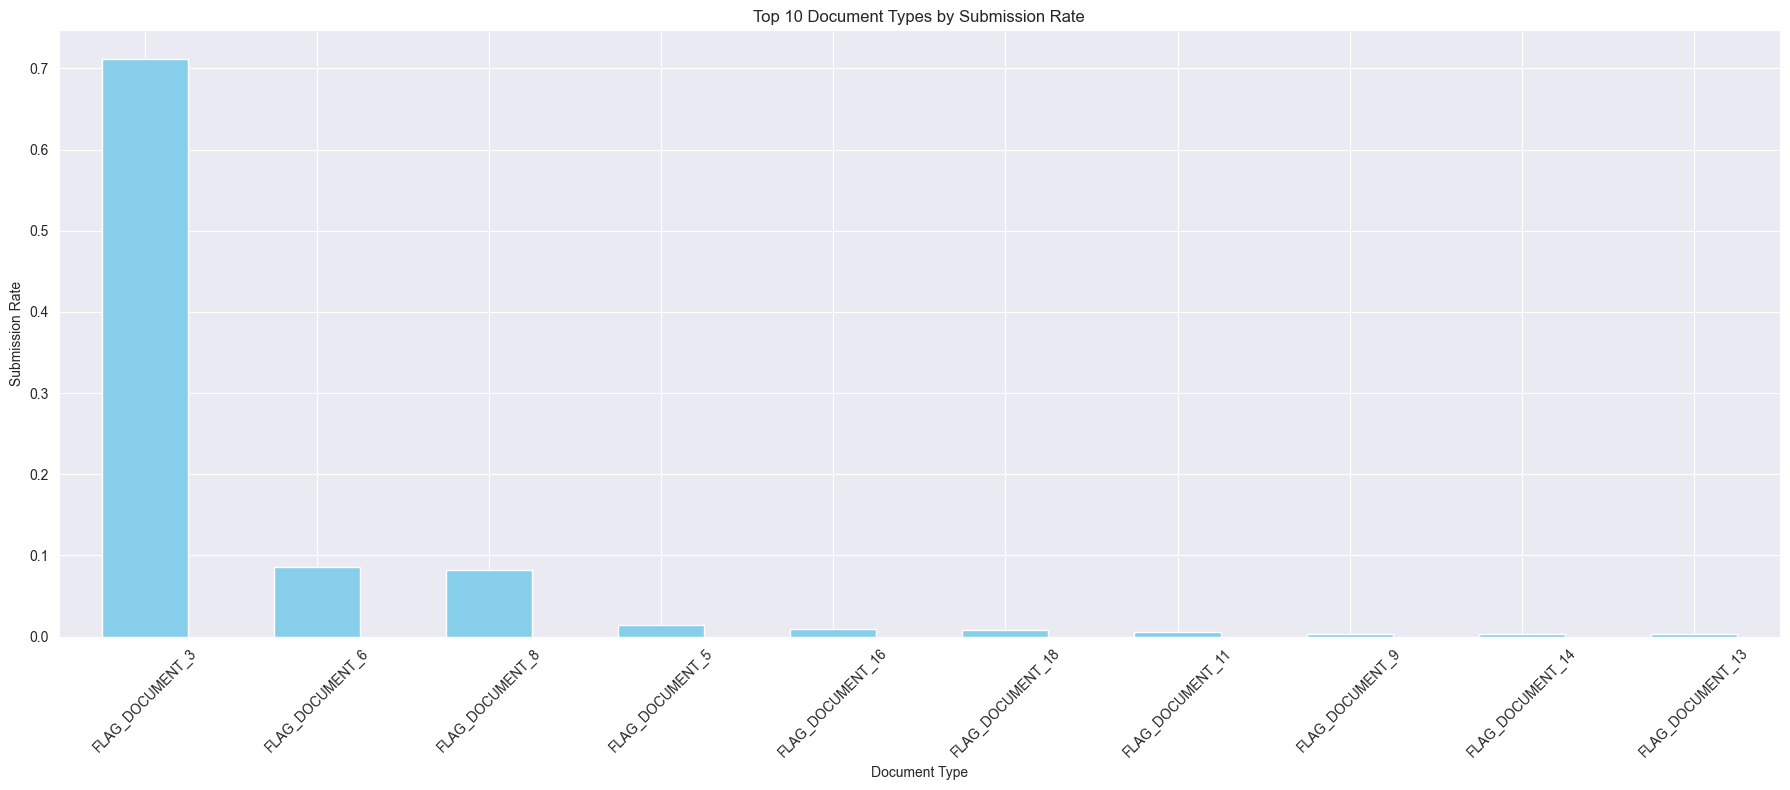

In [35]:
# Analyze document verification patterns
doc_summary = case_data[doc_cols].mean().sort_values(ascending=False)
top_docs = doc_summary.head(10)

plt.figure(figsize=(18, 8))
top_docs.plot(kind='bar', color='skyblue')
plt.title('Top 10 Document Types by Submission Rate')
plt.xlabel('Document Type')
plt.ylabel('Submission Rate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**5. Correlation Analysis and Feature Selection**

In [26]:
# Identify variables most correlated with target
numeric_cols = case_data.select_dtypes(include=[np.number]).columns
cor_matrix = case_data[numeric_cols].corr()

# Target correlations
target_cor = cor_matrix['TARGET'].drop('TARGET').abs().sort_values(ascending=False)

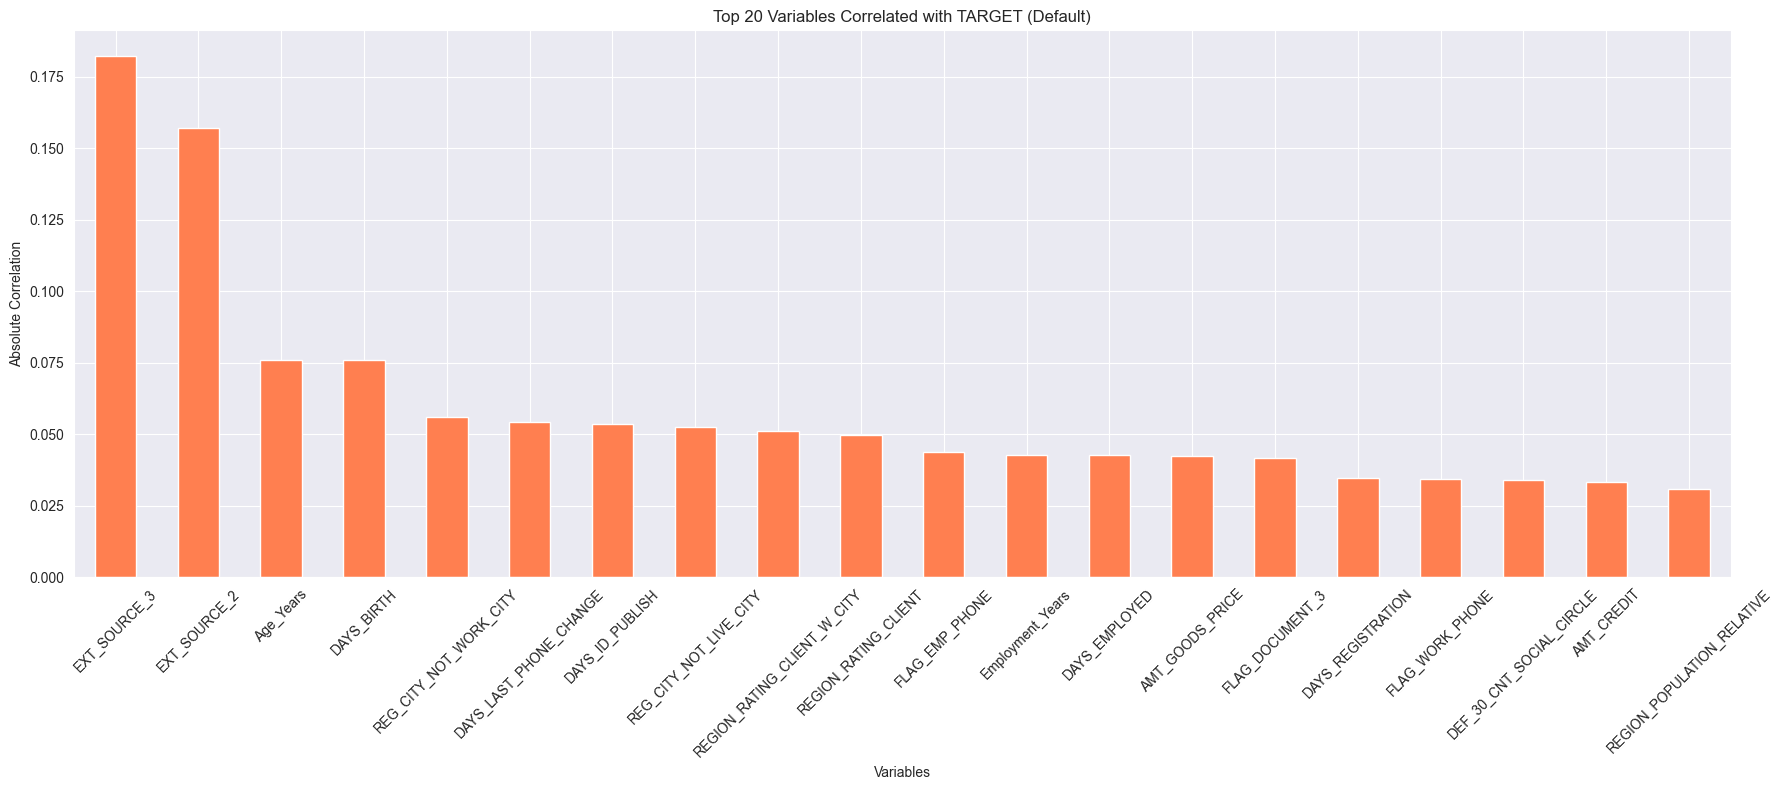

In [36]:
# Visualize top correlations
plt.figure(figsize=(18, 8))
target_cor.head(20).plot(kind='bar', color='coral')
plt.title('Top 20 Variables Correlated with TARGET (Default)')
plt.xlabel('Variables')
plt.ylabel('Absolute Correlation')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [37]:

print("Top 10 correlations with target:")
print(target_cor.head(10))

# High correlation features (potential redundancy)
high_cor_pairs = []
for i in range(len(cor_matrix.columns)):
    for j in range(i+1, len(cor_matrix.columns)):
        if abs(cor_matrix.iloc[i, j]) > 0.8:
            high_cor_pairs.append((cor_matrix.columns[i], cor_matrix.columns[j],
                                  cor_matrix.iloc[i, j]))

print(f"Found {len(high_cor_pairs)} highly correlated pairs (>0.8)")

Top 10 correlations with target:
EXT_SOURCE_3                   0.182136
EXT_SOURCE_2                   0.157087
Age_Years                      0.076066
DAYS_BIRTH                     0.075849
REG_CITY_NOT_WORK_CITY         0.056060
DAYS_LAST_PHONE_CHANGE         0.054346
DAYS_ID_PUBLISH                0.053487
REG_CITY_NOT_LIVE_CITY         0.052571
REGION_RATING_CLIENT_W_CITY    0.051197
REGION_RATING_CLIENT           0.049742
Name: TARGET, dtype: float64
Found 12 highly correlated pairs (>0.8)



**6. Data Quality and Outlier Detection**

Duplicate records: 0
Variables with outliers:
REGION_RATING_CLIENT: 5268 outliers
REGION_RATING_CLIENT_W_CITY: 5120 outliers
DAYS_EMPLOYED: 4738 outliers
Employment_Years: 4725 outliers
REG_CITY_NOT_WORK_CITY: 4584 outliers
FLAG_WORK_PHONE: 4027 outliers
FLAG_EMP_PHONE: 3599 outliers
LIVE_CITY_NOT_WORK_CITY: 3551 outliers
AMT_REQ_CREDIT_BUREAU_QRT: 3170 outliers
AMT_REQ_CREDIT_BUREAU_MON: 2832 outliers


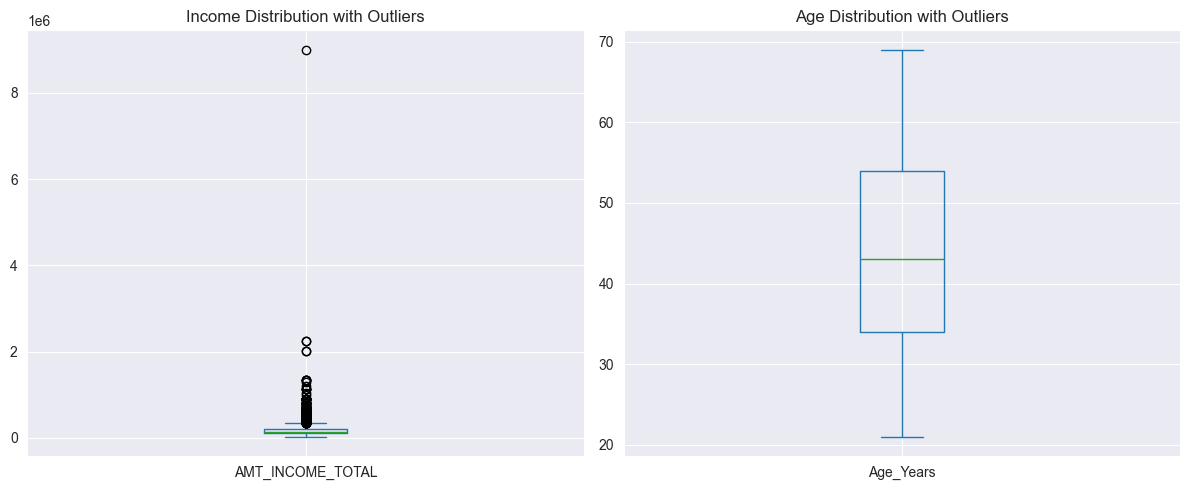

In [38]:
# Following systematic quality checks from healthcare team
# Check for duplicates
duplicate_count = case_data.duplicated().sum()
print(f"Duplicate records: {duplicate_count}")

# Outlier detection using IQR method
def detect_outliers_iqr(series):
    if not pd.api.types.is_numeric_dtype(series):
        return 0
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    outliers = (series < (Q1 - 1.5 * IQR)) | (series > (Q3 + 1.5 * IQR))
    return outliers.sum()

# Apply to all numeric columns
outlier_counts = {col: detect_outliers_iqr(case_data[col])
                  for col in numeric_cols}
outlier_summary = {k: v for k, v in outlier_counts.items() if v > 0}

print("Variables with outliers:")
for var, count in sorted(outlier_summary.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"{var}: {count} outliers")

# Visualize outliers for key variables
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
case_data['AMT_INCOME_TOTAL'].plot(kind='box', ax=axes[0], title='Income Distribution with Outliers')
case_data['Age_Years'].plot(kind='box', ax=axes[1], title='Age Distribution with Outliers')
plt.tight_layout()
plt.show()



**7. Temporal/Phase-Based Feature Engineering**

In [43]:
# Following healthcare team's phase separation concept
# Create customer risk phases based on financial characteristics

# Define risk phases based on credit-to-income ratio
conditions = [
    case_data['Credit_Income_Ratio'] <= 2,
    (case_data['Credit_Income_Ratio'] > 2) & (case_data['Credit_Income_Ratio'] <= 5),
    case_data['Credit_Income_Ratio'] > 5
]
choices = ['Low_Risk', 'Medium_Risk', 'High_Risk']
case_data['Risk_Phase'] = np.select(conditions, choices, default='Unknown')

In [44]:
# Analyze target rate by risk phase
phase_analysis = case_data.groupby('Risk_Phase')['TARGET'].agg(['count', 'mean']).round(3)
phase_analysis.columns = ['Count', 'Default_Rate']
print("Default rate by risk phase:")
print(phase_analysis)

Default rate by risk phase:
             Count  Default_Rate
Risk_Phase                      
High_Risk     5235         0.069
Low_Risk      4959         0.076
Medium_Risk   9806         0.083


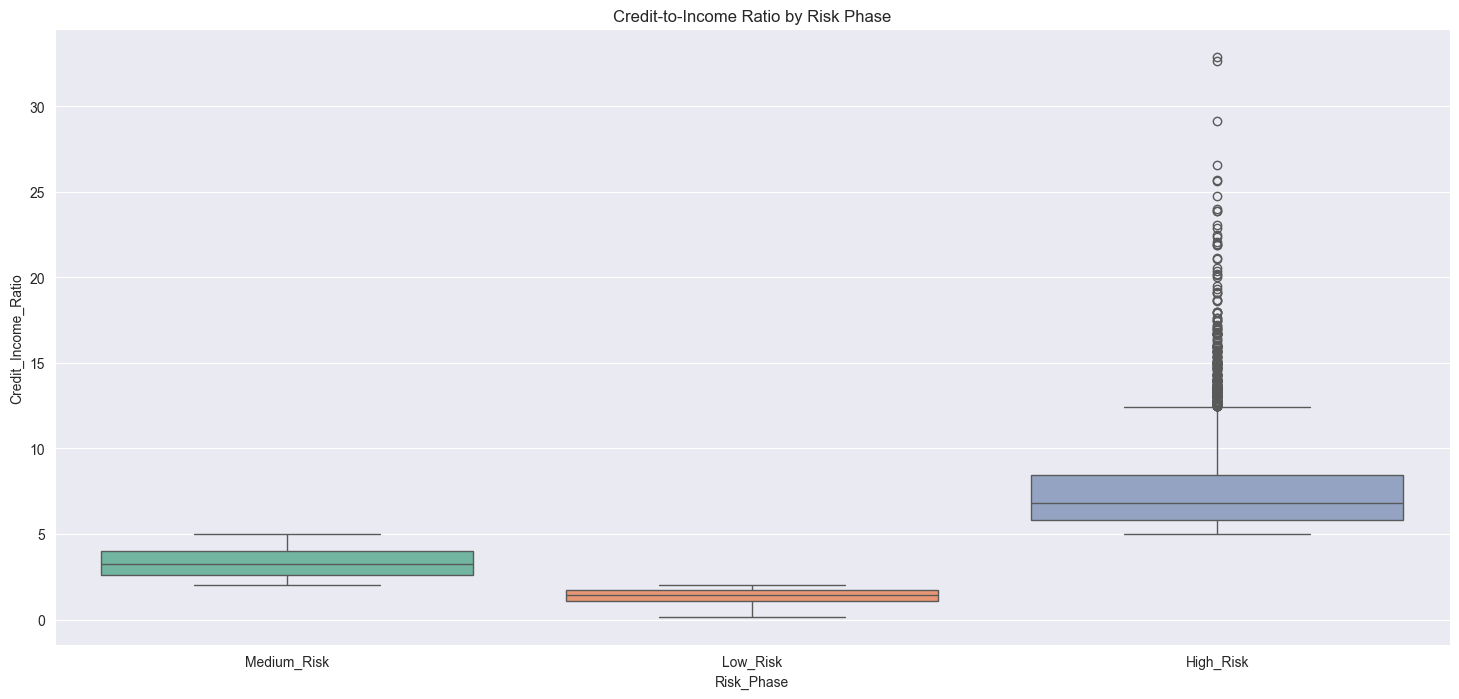

In [57]:
# Visualize by phase
plt.figure(figsize=(18, 8))
# sns.boxplot(column='Credit_Income_Ratio', by='Risk_Phase')
sns.boxplot(data=case_data, x='Risk_Phase', y='Credit_Income_Ratio', palette='Set2',  hue='Risk_Phase', log_scale=False)
plt.title('Credit-to-Income Ratio by Risk Phase')
plt.show()


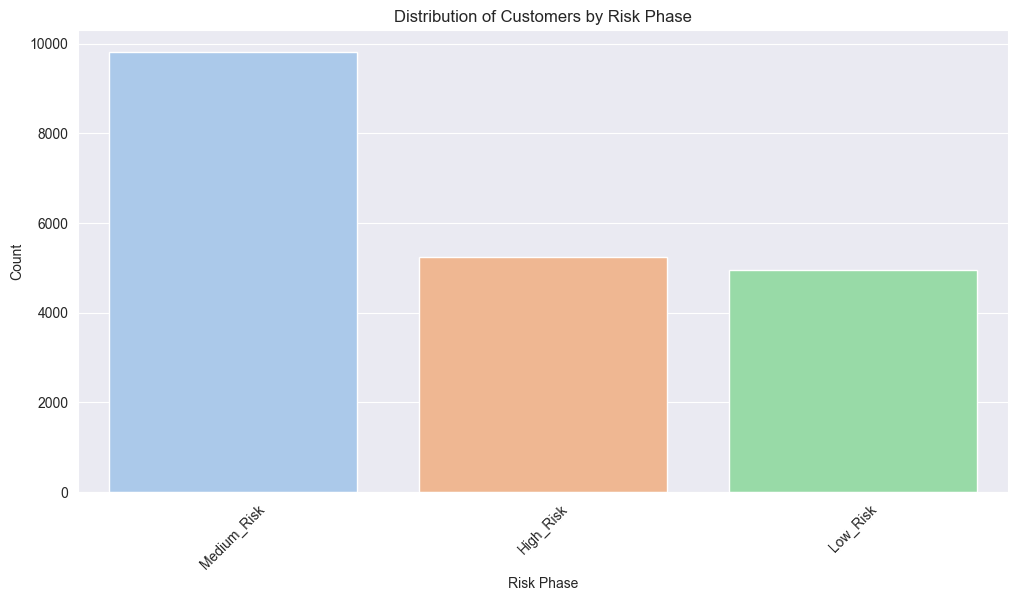

In [50]:
# Phase distribution
phase_dist = case_data['Risk_Phase'].value_counts().reset_index()
phase_dist.columns = ['Risk_Phase', 'Count']

plt.figure(figsize=(12, 6))
sns.barplot(data=phase_dist, x='Risk_Phase', y='Count', palette='pastel', hue='Risk_Phase')

plt.title('Distribution of Customers by Risk Phase')
plt.ylabel('Count')
plt.xlabel('Risk Phase')
plt.xticks(rotation=45)  # optional, for readability
plt.show()

**Why These Steps Are Critical for Our Dataset:**

1. **Missing Value Strategy**: Our loan dataset has systematic missing patterns in employment and credit bureau data that need domain-informed handling
2. **Class Imbalance Focus**: With only ~7.7% default cases, we need specialized sampling and evaluation strategies  
3. **Bias Prevention**: Loan decisions have strict regulatory requirements (FCRA, ECOA) - fairness is mandatory
4. **Financial Ratios**: Customers vary in income and credit needs - raw amounts would bias toward high-income segments
5. **Feature Engineering**: Transform raw financial data into meaningful risk indicators (debt-to-income, employment stability)
6. **Quality Assurance**: Systematic checks prevent model failures from data quality issues
7. **Risk-Based Segmentation**: Different risk profiles require different evaluation approaches and intervention strategies

This systematic Python approach, adapted from healthcare competition methodology, provides a robust foundation for our loan default prediction model while ensuring regulatory compliance and interpretability.

### Key Insights for Our Case Competition:

**1. Systematic Methodology**: The winning team used a methodical, well-documented approach with clear rationale for every decision

**2. Fairness as Core Requirement**: They built systematic bias prevention rather than hoping for fairness - critical for loan models with regulatory requirements

**3. Domain-Informed Feature Engineering**: Success came from understanding healthcare workflows and patient journeys, not just statistical methods - we need similar understanding of credit risk and borrower behavior

**4. Multi-Phase Approach**: They recognized different patient groups need different intervention timing - we should consider pre-approval vs post-approval risk factors

**5. Interpretability Focus**: Emphasis on understanding "why" rather than just predicting "who" enabled actionable business recommendations

**6. Business Impact Validation**: They measured success through healthcare outcomes and cost savings, not just model metrics - we should validate through portfolio performance

These insights will guide our preprocessing strategy to create a fair, interpretable, and business-valuable loan default prediction model that follows proven competition-winning methodologies.